<a href="https://colab.research.google.com/github/AadityaBodke/finetune-mrcnn/blob/main/dobs_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-cpttwmv0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-cpttwmv0
  Resolved https://github.com/facebookresearch/detectron2.git to commit 31bebdea147c96f8a00a0d55931858bf727ae370
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [5]:
import logging
from collections import OrderedDict
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image
import time

In [ ]:
VERSION = 2
rf = Roboflow(api_key="f8xlJP6dMDzUcqJL4AxF")
project = rf.workspace('dobs-tfc87').project('spine-seg-8jfww')
# project.list_projects()
dataset = project.version(VERSION).download("coco-segmentation")

In [ ]:
# !rm -rf spine-seg-1

In [6]:
register_coco_instances("spine_poly_train", {}, f"./spine-seg-{VERSION}/train/_annotations.coco.json", f"./spine-seg-{VERSION}/train/")
register_coco_instances("spine_poly_valid", {}, f"./spine-seg-{VERSION}/valid/_annotations.coco.json", f"./spine-seg-{VERSION}/valid/")
register_coco_instances("spine_poly_test", {}, f"./spine-seg-{VERSION}/test/_annotations.coco.json", f"./spine-seg-{VERSION}/test/")

NameError: name 'VERSION' is not defined

In [ ]:
dataset_train = DatasetCatalog.get("spine_poly_train")

for d in random.sample(dataset_train, 3):
  fig, ax = plt.subplots()
  im = Image.open(d['file_name'])
  ax.imshow(im)
  for ann in d['annotations']:
      for poly in ann['segmentation']:
          x = poly[0::2]
          y = poly[1::2]
          ax.plot(x,y, linewidth=2, color='red')

WARNING [08/06 08:14:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/06 08:14:53 d2.data.datasets.coco]: Loaded 1746 images in COCO format from ./spine-seg-2/train/_annotations.coco.json
Image file: ./spine-seg-2/train/IMG_20191014_211950_jpg.rf.342453652a653a9c78508250182ae2bd.jpg
Annotations:
  Annotation 0:
    Segmentation: [[27.653, 153.514, 8.923, 151.433, 14.126, 593.333, 32.856, 590.558, 27.653, 153.514]]
  Annotation 1:
    Segmentation: [[48.465, 152.126, 23.491, 152.82, 32.336, 593.333, 50.026, 592.64, 48.465, 152.126]]
  Annotation 2:
    Segmentation: [[65.114, 159.063, 45.343, 163.226, 50.026, 594.027, 63.554, 590.558, 65.114, 159.063]]
  Annotation 3:
    Segmentation: [[80.203, 161.145, 64.594, 159.757, 62.513, 591.946, 81.243, 596.108, 80.203, 161.145]]
  Annotation 4:
    Segmentation: [[94.771, 158.37, 78.122, 158.37, 79.683, 592.64, 97.373, 592.64, 94.771, 158.37]]
  Annotation 5:
    Segmentat

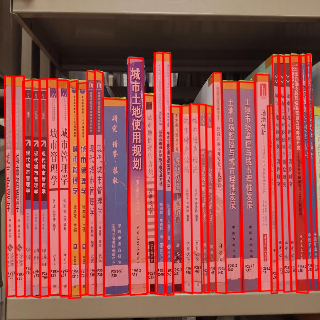



Image file: ./spine-seg-2/train/crop-159_png_jpg.rf.d7e6c4b0d400808d7c6c049aa441f6b7.jpg
Annotations:
  Annotation 0:
    Segmentation: [[569.224, 138.622, 562.22, 130.951, 511.031, 565.265, 514.803, 573.527, 518.574, 577.657, 523.693, 575.297, 582.426, 146.294, 579.462, 147.474, 574.882, 145.703, 569.224, 138.622]]
  Annotation 1:
    Segmentation: [[466.847, 571.166, 481.934, 589.459, 548.749, 170.488, 531.114, 152.752, 466.847, 571.166]]
  Annotation 2:
    Segmentation: [[436.673, 580.608, 439.367, 586.509, 443.677, 589.459, 448.527, 587.689, 514.533, 171.668, 509.414, 166.947, 504.834, 160.456, 499.8, 154.963, 436.673, 580.608]]
  Annotation 3:
    Segmentation: [[373.63, 583.558, 379.287, 584.739, 455.532, 176.979, 448.257, 171.668, 442.896, 163.073, 367.703, 569.986, 370.397, 579.428, 373.63, 583.558]]
  Annotation 4:
    Segmentation: [[555.754, 565.265, 574.074, 574.117, 614.755, 199.403, 593.472, 182.29, 555.754, 565.265]]
  Annotation 5:
    Segmentation: [[39.349, 154.53,

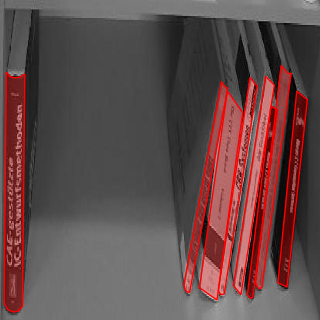



Image file: ./spine-seg-2/train/IMG_2122-Large_jpeg_jpg.rf.8ee57d530a68f18697780c390cd5d50e.jpg
Annotations:
  Annotation 0:
    Segmentation: [[351.446, 41.198, 335.257, 42.615, 331.262, 47.147, 332.653, 48.698, 333.067, 82.123, 335.039, 90.315, 342.862, 208.416, 345.124, 219.93, 365.294, 479.158, 378.336, 621.061, 379.903, 631.799, 381.989, 634.126, 396.932, 632.819, 403.272, 626.408, 410.91, 598.972, 415.726, 524.937, 401.781, 365.546, 397.527, 273.901, 394.02, 262.497, 387.276, 171.07, 378.809, 131.658, 374.015, 76.867, 363.265, 54.385, 351.446, 41.198]]
  Annotation 1:
    Segmentation: [[333.972, 640, 373.417, 636.549, 377.413, 632.017, 343.712, 246.822, 331.034, 58.878, 327.672, 49.134, 321.56, 43.813, 258.633, 56.011, 253.798, 58.107, 251.338, 65.85, 295.466, 563.063, 303.393, 639.329, 307.224, 640, 333.972, 640]]
  Annotation 2:
    Segmentation: [[299.444, 640, 301.307, 637.002, 249.512, 59.318, 241.055, 55.875, 203.988, 62.464, 198.747, 67.106, 249.496, 640, 299.444, 640]]

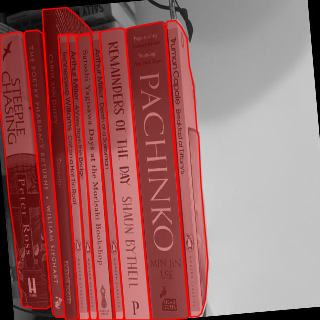

In [8]:
dataset_dicts = DatasetCatalog.get("spine_poly_train")
metadata = MetadataCatalog.get("spine_poly_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)

    print(f"Image file: {d['file_name']}")
    print("Annotations:")
    for i, ann in enumerate(d["annotations"]):
        print(f"  Annotation {i}:")
        if "segmentation" in ann:
            print(f"    Segmentation: {ann['segmentation']}")
            for seg in ann["segmentation"]:
                if isinstance(seg, list) and len(seg) > 4:
                    # Assuming seg is a list of coordinates [x1, y1, x2, y2, ...]
                    poly = [
                        (seg[j], seg[j + 1])
                        for j in range(0, len(seg), 2)
                    ]
                    visualizer.draw_polygon(poly, color="r", edge_color="r", alpha=0.3)
                else:
                    print(f"    Skipping invalid segmentation: {seg}")
        else:
            print("    No segmentation data found")

    out = visualizer.get_output()
    cv2_imshow(out.get_image()[:, :, ::-1])
    print("\n" + "="*50 + "\n")

In [ ]:
torch.cuda.is_available()

In [1]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("spine_poly_train",)  # Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("spine_poly_test",)  # Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 10  # batch size
cfg.SOLVER.BASE_LR = 0.00025  # LR
cfg.SOLVER.MAX_ITER = 10000 # We found that with a patience of 500, training will early stop before 10,000 iterations
cfg.SOLVER.STEPS = [] # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 # book and background
cfg.TEST.EVAL_PERIOD = 0 # Increase this number if you want to monitor validation performance during training
cfg.MODEL.DEVICE = "cuda"
cfg.OUTPUT_DIR = f"./output-{time.time()}"
PATIENCE = 500 #  Early stopping will occur after N iterations of no imporovement in total_loss

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

NameError: name 'get_cfg' is not defined

In [ ]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)

        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    break

# do_test(cfg, model)

[08/06 08:22:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:01, 138MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [08/06 08:22:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/06 08:22:31 d2.data.datasets.coco]: Loaded 1746 images in COCO format from ./spine-seg-2/train/_annotations.coco.json
[08/06 08:22:31 d2.data.build]: Removed 22 images with no usable annotations. 1724 images left.
[08/06 08:22:31 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    book    | 0            |    book    | 29832        |
|            |              |            |              |
|   total    | 29832        |            |              |
[08/06 08:22:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/06 08:22:31 d2.data.build]: Using training sampler Train

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)


[08/06 08:23:00 d2.utils.events]:  iter: 19  total_loss: 2.956  loss_cls: 0.9935  loss_box_reg: 0.6959  loss_mask: 0.6919  loss_rpn_cls: 0.2045  loss_rpn_loc: 0.3212     lr: 4.9953e-06  max_mem: 8572M
[08/06 08:23:27 d2.utils.events]:  eta: 3:45:18  iter: 39  total_loss: 2.804  loss_cls: 0.9378  loss_box_reg: 0.7153  loss_mask: 0.6888  loss_rpn_cls: 0.1924  loss_rpn_loc: 0.2609     lr: 9.9902e-06  max_mem: 8666M
[08/06 08:23:52 d2.utils.events]:  eta: 3:23:14  iter: 59  total_loss: 2.672  loss_cls: 0.8356  loss_box_reg: 0.7213  loss_mask: 0.6825  loss_rpn_cls: 0.157  loss_rpn_loc: 0.2714     lr: 1.4985e-05  max_mem: 8958M
[08/06 08:24:17 d2.utils.events]:  eta: 3:27:24  iter: 79  total_loss: 2.519  loss_cls: 0.7081  loss_box_reg: 0.7208  loss_mask: 0.6716  loss_rpn_cls: 0.1418  loss_rpn_loc: 0.2662     lr: 1.998e-05  max_mem: 8958M
[08/06 08:24:42 d2.utils.events]:  eta: 3:27:17  iter: 99  total_loss: 2.37  loss_cls: 0.6241  loss_box_reg: 0.738  loss_mask: 0.6581  loss_rpn_cls: 0.1126 

In [12]:
do_test(cfg, model)

WARNING [08/06 08:01:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/06 08:01:19 d2.data.datasets.coco]: Loaded 181 images in COCO format from ./spine-seg-2/test/_annotations.coco.json
[08/06 08:01:20 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    book    | 0            |    book    | 2889         |
|            |              |            |              |
|   total    | 2889         |            |              |
[08/06 08:01:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/06 08:01:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/06 08:01:20 d2.data.common]: Serializing 181 elements to byte tensors

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[08/06 08:01:21 d2.evaluation.evaluator]: Inference done 11/181. Dataloading: 0.0013 s/iter. Inference: 0.0435 s/iter. Eval: 0.0212 s/iter. Total: 0.0660 s/iter. ETA=0:00:11
[08/06 08:01:26 d2.evaluation.evaluator]: Inference done 87/181. Dataloading: 0.0014 s/iter. Inference: 0.0414 s/iter. Eval: 0.0232 s/iter. Total: 0.0661 s/iter. ETA=0:00:06
[08/06 08:01:31 d2.evaluation.evaluator]: Inference done 165/181. Dataloading: 0.0014 s/iter. Inference: 0.0405 s/iter. Eval: 0.0231 s/iter. Total: 0.0651 s/iter. ETA=0:00:01
[08/06 08:01:32 d2.evaluation.evaluator]: Total inference time: 0:00:11.537526 (0.065554 s / iter per device, on 1 devices)
[08/06 08:01:32 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.040386 s / iter per device, on 1 devices)
[08/06 08:01:32 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[08/06 08:01:32 d2.evaluation.coco_evaluation]: Saving results to ./output-1722926743.6290011/inference/spine_poly_test/coco_instances_re

OrderedDict([('bbox',
              {'AP': 62.3191314001865,
               'AP50': 87.86003624550641,
               'AP75': 73.22283001872297,
               'APs': 19.74733014803872,
               'APm': 54.52275698982526,
               'APl': 64.4255622307224,
               'AP-book': 62.3191314001865}),
             ('segm',
              {'AP': 47.60956161548789,
               'AP50': 71.43272461313434,
               'AP75': 54.82638187418527,
               'APs': 3.379340015021744,
               'APm': 29.180584535616106,
               'APl': 52.87133645809543,
               'AP-book': 47.60956161548789})])

In [13]:
final_checkpoint_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
if not os.path.exists(final_checkpoint_path):
    checkpointer.save("model_final")

cfg.MODEL.WEIGHTS = final_checkpoint_path  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[08/06 08:01:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output-1722926743.6290011/model_final.pth ...


In [14]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[08/06 08:01:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output-1722926743.6290011/model_final.pth ...


In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("spine_poly_valid", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "spine_poly_valid")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [08/06 08:01:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/06 08:01:50 d2.data.datasets.coco]: Loaded 199 images in COCO format from ./spine-seg-2/valid/_annotations.coco.json
[08/06 08:01:50 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    book    | 0            |    book    | 3410         |
|            |              |            |              |
|   total    | 3410         |            |              |
[08/06 08:01:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/06 08:01:50 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/06 08:01:50 d2.data.common]: Serializing 199 elements to byte tensor

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[08/06 08:01:51 d2.evaluation.evaluator]: Inference done 11/199. Dataloading: 0.0011 s/iter. Inference: 0.0389 s/iter. Eval: 0.0134 s/iter. Total: 0.0534 s/iter. ETA=0:00:10
[08/06 08:01:56 d2.evaluation.evaluator]: Inference done 104/199. Dataloading: 0.0015 s/iter. Inference: 0.0381 s/iter. Eval: 0.0142 s/iter. Total: 0.0538 s/iter. ETA=0:00:05
[08/06 08:02:01 d2.evaluation.evaluator]: Total inference time: 0:00:10.295366 (0.053069 s / iter per device, on 1 devices)
[08/06 08:02:01 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.037939 s / iter per device, on 1 devices)
[08/06 08:02:01 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[08/06 08:02:01 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[08/06 08:02:01 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[08/06 08:02:01 d2.evaluatio

In [1]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("spine_poly_test")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    im = Image.fromarray(out.get_image()[:, :, ::-1])
    im.show()

NameError: name 'os' is not defined

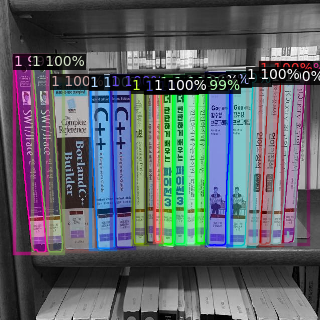

In [17]:
im

In [ ]:
print(cfg.OUTPUT_DIR)

./output-1721436191.8616414


In [ ]:
!cp -r "/content/output-1721436191.8616414" "/content/drive/MyDrive"

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
! pip install torch torchvision onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 109.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinu

In [ ]:
import torch
import onnx
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model
from detectron2.structures import Instances
import numpy as np

class MaskRCNNWrapper(torch.nn.Module):
    def __init__(self, model):
        super(MaskRCNNWrapper, self).__init__()
        self.model = model

    def forward(self, images):
        inputs = [{"image": image, "height": image.shape[1], "width": image.shape[2]} for image in images]
        outputs = self.model.inference(inputs, do_postprocess=False)

        instances = outputs[0]['instances']

        # Extract the relevant outputs
        pred_boxes = instances.pred_boxes.tensor
        scores = instances.scores
        pred_classes = instances.pred_classes
        pred_masks = instances.pred_masks

        return pred_boxes, scores, pred_classes, pred_masks

# # Load your config and model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
# cfg.MODEL.DEVICE = "cpu"   # or "cuda"

# Build the model
model = build_model(cfg)
model.eval()

# Load the model weights
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

# Wrap the model
wrapper_model = MaskRCNNWrapper(model)
wrapper_model.eval()

# Dummy input for tracing
dummy_input = torch.randn(1, 3, 800, 800)

# Export the model to ONNX
torch.onnx.export(wrapper_model, dummy_input, "mask_rcnn.onnx",
                  opset_version=11,   # Specify the ONNX version to use
                  input_names=['input'],   # The model's input names
                  output_names=['boxes', 'scores', 'classes', 'masks'], # The model's output names
                  dynamic_axes={'input': {0: 'batch_size'},
                                'boxes': {0: 'batch_size', 1: 'num_boxes'},
                                'scores': {0: 'batch_size', 1: 'num_boxes'},
                                'classes': {0: 'batch_size', 1: 'num_boxes'},
                                'masks': {0: 'batch_size', 1: 'num_boxes', 2: 'height', 3: 'width'}}) # Enable dynamic batch size

[07/19 07:30:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output-1721359488.494873/model_final.pth ...


Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
Converting a tensor to a Python boolean m

TypeError: list indices must be integers or slices, not str

[07/19 07:10:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output-1721359488.494873/model_final.pth ...


IndexError: too many indices for tensor of dimension 3